# %% [markdown]

# Modelo de prediccion de abandono de clientes para empresa Interconnect
 ---
 Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

 Nuestra meta es construir un modelo que nos ayude a predecir si un cliente esta en riesgo de cancelar el servicio, Interconnect nos pide obtener una metrica igual o mayor a 0.88 en la curva AUC-ROC.

# %% [markdown]

# Índice
 - [Inicialización](#Inicializacion)
    - [Corrección de datos para dataset de contratos](#Correccion-de-datos-para-dataset-de-contratos)
    - [Corrección de datos para dataset de internet](#Correccion-de-datos-para-dataset-de-internet)
    - [Corrección de datos para dataset de info personal](#Correccion-de-datos-para-dataset-de-info-personal)
    - [Corrección de datos para dataset de phone](#Correccion-de-datos-para-dataset-de-phone)
 - [Creación de dataset mayor](#Creacion-de-dataset-mayor)
    - [Llenado de valores ausentes](#Llenado-de-valores-ausentes)
 - [Feature Engineering](#Feature-Engineering)
    - [Codificación](#Codificacion)
    - [Datasets para entrenamiento, validacion y prueba](#Datasets-para-entrenamiento,-validacion-y-prueba)
 - [Entrenamiento de modelos](#Entrenamiento-de-modelos)
    - [Modelo 1 - Regresión logística](#Modelo-1-Regresion-logistica)
    - [Modelo 2 - Bosque aleatorio](#Modelo-2-Bosque-aleatorio)
    - [Modelo 3 - LightGBM](#Modelo-3-LightGBM)
    - [Modelo 4 - XGBoost](#Modelo-4-XGBoost)
    - [Modelo 5 - CatBoost](#Modelo-5-CatBoost)
 - [Análisis de resultados](#Analisis-de-resultados)
 - [Selección del mejor modelo y validación con dataset de pruebas](#Seleccion-del-mejor-modelo-y-validacion-con-dataset-de-pruebas)

# %% [markdown]

#  Inicializacion

In [ ]:
# %% 

import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

In [ ]:
# %%

df_contracts = pd.read_csv(r"C:\Users\luisP\OneDrive\Documentos\Proyecto Final\contract.csv")
df_internet = pd.read_csv(r"C:\Users\luisP\OneDrive\Documentos\Proyecto Final\internet.csv")
df_personal = pd.read_csv(r"C:\Users\luisP\OneDrive\Documentos\Proyecto Final\personal.csv")
df_phone = pd.read_csv(r"C:\Users\luisP\OneDrive\Documentos\Proyecto Final\phone.csv")

# %% [markdown]

# Correccion de datos para dataset de contratos

In [ ]:
# %%

df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
# %%

df_contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
# %%

df_contracts.duplicated().sum()

0

In [ ]:
# %%

# df_contracts['TotalCharges'] = df_contracts['TotalCharges'].astype('float64')

In [ ]:
# %%

df_contracts[df_contracts['TotalCharges'] == ' '] 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [ ]:
# %%

df_contracts['TotalCharges'] = df_contracts['TotalCharges'].where(df_contracts['TotalCharges'] != ' ', df_contracts['MonthlyCharges'])

In [ ]:
# %%

df_contracts[df_contracts['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [ ]:
# %%

df_contracts['TotalCharges'] = df_contracts['TotalCharges'].astype('float64')

In [ ]:
# %%

df_contracts[df_contracts['customerID'] == '4472-LVYGI']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55


# %% [markdown]

 Descubrimos que la columna 'TotalCharges' estaba catalogada como objeto, ya que tenia strings vacios. Para corregir lo anterior utilizamos el metodo where, el cual nos ayuda a ubicar los strings y sustituirlos por el valor que escojamos, en este caso fue por el valor de la columna 'MonthlyCharges'. Un vez realizado lo anterior validamos que se hayan realizado los cambios mencionados, buscamos el ID del cliente y verificamos que el cambio fue realizado con exito.

In [ ]:
# %%

df_contracts['BeginDate'] = pd.to_datetime(df_contracts['BeginDate'])

df_contracts['Month'] = df_contracts['BeginDate'].dt.month
df_contracts['Year'] = df_contracts['BeginDate'].dt.year

df_contracts = df_contracts.drop('BeginDate', axis=1)

# %% [markdown]

 Aqui hicimos un simple cambio de tipo de datos en la columna 'BeginDate', de objeto a datetime, esto con la idea de crear 2 nuevas columnas 'Month' y 'Year'.

# %% [markdown]

# Correccion de datos para dataset de internet

In [ ]:
# %%

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
# %%

df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
# %%

df_internet.duplicated().sum()

0

# %% [markdown]

# Correccion de datos para dataset de info personal

In [ ]:
# %%

df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
# %%

df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
# %%

df_personal.duplicated().sum()

0

# %% [markdown]

# Correccion de datos para dataset de phone

In [ ]:
# %%

df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
# %%

df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
# %%

df_phone.duplicated().sum()

0

# %% [markdown]

# Creacion de dataset mayor
 ---
 Tenemos diferentes datasets, cada uno cuenta con la columna customerID la cual contiene un código único asignado a cada cliente, este nos servira para juntar todo los dataset y crear uno con el cual vamos a trabajar para mas adelante construir nuestro modelo de prediccion.

In [ ]:
# %%

df_merge = df_contracts.merge(df_personal, on='customerID')
df_merge = df_merge.merge(df_phone, on='customerID', how='outer')
df = df_merge.merge(df_internet, on='customerID', how='outer')

df

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Month,Year,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0002-ORFBO,No,One year,Yes,Mailed check,65.60,593.30,5,2019,Female,...,Yes,Yes,No,DSL,No,Yes,No,Yes,Yes,No
1,0003-MKNFE,No,Month-to-month,No,Mailed check,59.90,542.40,5,2019,Male,...,No,No,Yes,DSL,No,No,No,No,No,Yes
2,0004-TLHLJ,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.90,280.85,9,2019,Male,...,No,No,No,Fiber optic,No,No,Yes,No,No,No
3,0011-IGKFF,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.00,1237.85,12,2018,Male,...,Yes,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes
4,0013-EXCHZ,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.90,267.40,9,2019,Female,...,Yes,No,No,Fiber optic,No,No,No,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,No,One year,No,Mailed check,55.15,742.90,1,2019,Female,...,No,No,No,DSL,Yes,No,No,Yes,No,No
7039,9992-RRAMN,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.70,2,2018,Male,...,Yes,No,Yes,Fiber optic,No,No,No,No,No,Yes
7040,9992-UJOEL,No,Month-to-month,Yes,Mailed check,50.30,92.75,12,2019,Male,...,No,No,No,DSL,No,Yes,No,No,No,No
7041,9993-LHIEB,No,Two year,No,Mailed check,67.85,4627.65,7,2014,Male,...,Yes,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes


In [ ]:
# %%

df.duplicated().sum()

0

# %% [markdown]

# Llenado de valores ausentes
---
 Ya que unimos los datasets de manera externa quedaron demasiadas filas con valores nulos. A continuacion veremos la cantidad extacta y como seran rellenados.

In [ ]:
# %%

df.isna().sum()

customerID             0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Month                  0
Year                   0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [ ]:
# %%

df[df['MultipleLines'].isna()]

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Month,Year,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
10,0017-DINOC,No,Two year,No,Credit card (automatic),45.20,2460.55,8,2015,Male,...,No,No,NaN,DSL,Yes,No,No,Yes,Yes,No
14,0019-GFNTW,No,Two year,No,Bank transfer (automatic),45.05,2560.10,6,2015,Female,...,No,No,NaN,DSL,Yes,Yes,Yes,Yes,No,No
16,0020-JDNXP,No,One year,No,Mailed check,61.25,1993.20,4,2017,Female,...,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,Yes
19,0023-HGHWL,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,25.10,25.10,10,2019,Male,...,No,No,NaN,DSL,No,No,No,No,No,No
25,0032-PGELS,2019-11-01 00:00:00,Month-to-month,No,Bank transfer (automatic),30.50,30.50,10,2019,Female,...,Yes,Yes,NaN,DSL,Yes,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,9906-NHHVC,No,Two year,Yes,Bank transfer (automatic),53.50,3517.90,9,2014,Female,...,No,No,NaN,DSL,No,Yes,Yes,No,Yes,Yes
6980,9907-SWKKF,2019-11-01 00:00:00,Month-to-month,No,Mailed check,25.05,25.05,10,2019,Female,...,No,No,NaN,DSL,No,No,No,No,No,No
6996,9928-BZVLZ,No,Two year,No,Mailed check,49.85,552.10,2,2019,Female,...,No,No,NaN,DSL,Yes,No,Yes,Yes,No,Yes
7016,9955-QOPOY,No,One year,Yes,Credit card (automatic),60.80,4263.40,5,2014,Male,...,Yes,No,NaN,DSL,No,Yes,Yes,Yes,Yes,Yes


In [ ]:
# %%

df[df['InternetService'].isna()]

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Month,Year,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
20,0023-UYUPN,No,One year,No,Electronic check,25.20,1306.30,12,2015,Female,...,Yes,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0030-FNXPP,No,Month-to-month,No,Mailed check,19.85,57.20,11,2019,Female,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,0031-PVLZI,2020-01-01 00:00:00,Month-to-month,No,Mailed check,20.35,76.35,9,2019,Female,...,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,0040-HALCW,No,Two year,No,Credit card (automatic),20.40,1090.60,8,2015,Male,...,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,0042-JVWOJ,No,One year,Yes,Bank transfer (automatic),19.60,471.85,12,2017,Male,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,9970-QBCDA,No,Month-to-month,No,Credit card (automatic),19.70,129.55,8,2019,Female,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7028,9972-EWRJS,No,Two year,Yes,Bank transfer (automatic),19.25,1372.90,7,2014,Female,...,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7032,9975-GPKZU,No,Two year,No,Credit card (automatic),19.75,856.50,4,2016,Male,...,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7033,9975-SKRNR,No,Month-to-month,No,Mailed check,18.90,18.90,1,2020,Male,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# %%

df['InternetService'].fillna('No service', inplace=True)

df.fillna('No', inplace=True)

# %% [markdown]

 Rellenamos los valores ausententes siguiendo la logica de que si hay un dato faltante es porque no ha sido solocitado el servicio, hay que recordar que los datasets originales de internet y phone contaban con 5,517 y 6,361 clientes registrados respectivamente.

In [ ]:
# %%

df.sample(10)

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Month,Year,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4909,6907-NZZIJ,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,99.15,3615.60,12,2016,Female,...,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,Yes
4178,5906-DVAPM,No,One year,Yes,Credit card (automatic),75.00,4213.90,7,2015,Female,...,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No
6735,9565-DJPIB,2019-10-01 00:00:00,Month-to-month,No,Mailed check,89.60,365.65,6,2019,Female,...,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No
1827,2665-NPTGL,No,Month-to-month,Yes,Bank transfer (automatic),98.10,2510.70,12,2017,Female,...,Yes,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
3295,4702-HDRKD,No,One year,Yes,Bank transfer (automatic),49.35,3321.35,7,2014,Male,...,No,No,No,DSL,Yes,No,Yes,Yes,Yes,No
5406,7617-EYGLW,No,Month-to-month,No,Electronic check,19.45,19.45,1,2020,Male,...,No,No,No,No service,No,No,No,No,No,No
415,0617-AQNWT,2019-11-01 00:00:00,Two year,No,Electronic check,47.85,3147.50,7,2014,Female,...,Yes,No,No,DSL,Yes,No,Yes,Yes,No,Yes
6367,9025-ZRPVR,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,18.95,185.60,1,2019,Male,...,No,No,No,No service,No,No,No,No,No,No
6916,9819-FBNSV,No,Month-to-month,Yes,Bank transfer (automatic),72.25,2575.45,1,2017,Male,...,Yes,No,No,Fiber optic,No,No,No,No,No,No
6690,9504-YAZWB,No,Two year,No,Mailed check,20.25,1048.45,9,2015,Female,...,No,No,No,No service,No,No,No,No,No,No


# %% [markdown]

 Tenemos nuestro dataset listo, podemos continuar.

# %% [markdown]

# Feature Engineering
 ---
 Vamos a utilizar diferentes tecnicas para que nuestro dataset tenga informacion de calidad y pueda ser utilizado para entrenar un modelo de aprendizaje automatico.

In [ ]:
# %%

df['EndDate'] = df['EndDate'].where(df['EndDate'] == 'No', 1)
df['EndDate'].replace('No', 0, inplace=True)

In [ ]:
# %%

df.head()

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Month,Year,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0002-ORFBO,0,One year,Yes,Mailed check,65.6,593.30,5,2019,Female,...,Yes,Yes,No,DSL,No,Yes,No,Yes,Yes,No
1,0003-MKNFE,0,Month-to-month,No,Mailed check,59.9,542.40,5,2019,Male,...,No,No,Yes,DSL,No,No,No,No,No,Yes
2,0004-TLHLJ,1,Month-to-month,Yes,Electronic check,73.9,280.85,9,2019,Male,...,No,No,No,Fiber optic,No,No,Yes,No,No,No
3,0011-IGKFF,1,Month-to-month,Yes,Electronic check,98.0,1237.85,12,2018,Male,...,Yes,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes
4,0013-EXCHZ,1,Month-to-month,Yes,Mailed check,83.9,267.40,9,2019,Female,...,Yes,No,No,Fiber optic,No,No,No,Yes,Yes,No


In [ ]:
# %%

target = df['EndDate']
features = df.drop(['EndDate', 'customerID'], axis=1)

# %% [markdown]

# Codificacion
 ---
 En este dataset existen columnas categoricas que cuentan con 2 valores (Yes y No), por lo que no considero necesario utilizar el método One-Hot para codificar los valores en ellas, en su lugar vamos a sustuir por 1 los valores afirmativos y 0 los negativos.

In [ ]:
# %%

yesno_col = ['PaperlessBilling', 'Partner', 'Dependents', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in yesno_col:
    features[col].replace('Yes', '1', inplace=True)
    features[col].replace('No', '0', inplace=True)
    features[col] = features[col].astype('int')

In [ ]:
# %%

cat_col = ['PaymentMethod', 'Type', 'InternetService', 'gender']

dummies = pd.get_dummies(features[cat_col], drop_first=True)
features = pd.concat([features, dummies], axis=1)
features.drop(cat_col, axis=1, inplace=True)

In [ ]:
# %%

features.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,Month,Year,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,...,StreamingTV,StreamingMovies,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No service,gender_Male
0,1,65.6,593.30,5,2019,0,1,1,0,0,...,1,0,False,False,True,True,False,False,False,False
1,0,59.9,542.40,5,2019,0,0,0,1,0,...,0,1,False,False,True,False,False,False,False,True
2,1,73.9,280.85,9,2019,0,0,0,0,0,...,0,0,False,True,False,False,False,True,False,True
3,1,98.0,1237.85,12,2018,1,1,0,0,0,...,1,1,False,True,False,False,False,True,False,True
4,1,83.9,267.40,9,2019,1,1,0,0,0,...,1,0,False,False,True,False,False,True,False,False


# %% [markdown]

# Datasets para entrenamiento, validacion y prueba

In [ ]:
# %%

features_train, sub_features, target_train, sub_target = train_test_split(
    features, target, test_size=0.40, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    sub_features, sub_target, test_size=0.50, random_state=12345)

features_train.shape, features_valid.shape, features_test.shape

((4225, 23), (1409, 23), (1409, 23))

# %% [markdown]

 Entrenamiento de modelos
 ---
 A continuación, utilizaremos diferentes algoritmos de poderosas librerías como Scikit-learn, XGBoost, LightGBM, CatBoost, y usaremos diferentes técnicas para optimizarlos con el fin de encontrar el mejor modelo y alcanzar nuestra meta.

In [ ]:
# %%

def metrics(model, features, target):
    predictions = model.predict(features)

    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]

    auc_roc = roc_auc_score(target, probabilities_one)

    f1 = f1_score(target, predictions)

    final_score = cross_val_score(model, features, target, cv=5).mean()

    confusion_matriz = confusion_matrix(target.tolist(), predictions.tolist())

    return auc_roc, f1, final_score, confusion_matriz

# %% [markdown]

# Modelo 1 Regresion logistica

In [ ]:
# %%

%%time
model_1 = LogisticRegression(random_state=54321, solver='liblinear').fit(features_train, target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_1, features=features_valid, target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.8627507236724133
F1 score: 0.6255506607929515
Puntuación media de la evaluación del modelo: 0.8168900330632745
Matriz de confusion:
[[941  89]
 [166 213]]
CPU times: total: 62.5 ms
Wall time: 90.3 ms


<Axes: >

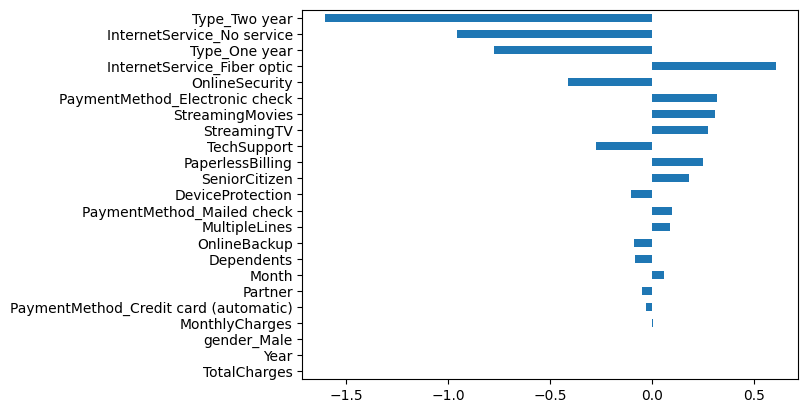

In [ ]:
# %%

coef = model_1.coef_.tolist()

(pd.Series(coef[0], index=model_1.feature_names_in_)
 .sort_values(key=abs)
 .plot.barh()
)

In [ ]:
# %%

rfe = RFE(model_1, n_features_to_select=5)

rfe.fit(features_train, target_train)

RFE(estimator=LogisticRegression(random_state=54321, solver='liblinear'),
    n_features_to_select=5)

In [ ]:
# %%

pd.DataFrame({'features':features_train.columns,
              'support': rfe.support_,
              'ranking':rfe.ranking_}).sort_values('ranking')

,features,support,ranking
20,InternetService_Fiber optic,True,1
19,Type_Two year,True,1
18,Type_One year,True,1
9,OnlineSecurity,True,1
21,InternetService_No service,True,1
16,PaymentMethod_Electronic check,False,2
12,TechSupport,False,3
10,OnlineBackup,False,4
0,PaperlessBilling,False,5
17,PaymentMethod_Mailed check,False,6


In [ ]:
# %%

%%time
best_5_features = ['InternetService_Fiber optic', 'Type_Two year', 'Type_One year', 'OnlineSecurity', 'InternetService_No service']

model_1_1 = LogisticRegression(random_state=54321, solver='liblinear').fit(features_train[best_5_features], target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_1_1, features=features_valid[best_5_features], target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.8208289571432231
F1 score: 0.5937921727395412
Puntuación media de la evaluación del modelo: 0.7863784356780494
Matriz de confusion:
[[888 142]
 [159 220]]
CPU times: total: 31.2 ms
Wall time: 37.8 ms


# %% [markdown]

 El primer modelo arroja resultados decentes, me parece interesante que estos no mejoran reduciendo la dimensionalidad. La regresion logistica es un buen algoritmo, pero existen otros aun mas potentes, considero que este modelo nos servira como base para evaluar modelos mas poderosos.

# %% [markdown]

# Modelo 2 Bosque aleatorio

In [ ]:
# %%

%%time
model_2 = RandomForestClassifier(random_state=54321, class_weight='balanced', max_depth=9).fit(features_train, target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_2, features=features_valid, target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.8829828111791378
F1 score: 0.6757369614512472
Puntuación media de la evaluación del modelo: 0.8325130612553948
Matriz de confusion:
[[825 205]
 [ 81 298]]
CPU times: total: 1.2 s
Wall time: 1.27 s


In [ ]:
# %%

rfe = RFE(model_2, n_features_to_select=5)

rfe.fit(features_train, target_train)

RFE(estimator=RandomForestClassifier(class_weight='balanced', max_depth=9,
                                     random_state=54321),
    n_features_to_select=5)

In [ ]:
# %%

pd.DataFrame({'features':features_train.columns,
              'support': rfe.support_,
              'ranking':rfe.ranking_}).sort_values('ranking')

,features,support,ranking
1,MonthlyCharges,True,1
2,TotalCharges,True,1
3,Month,True,1
4,Year,True,1
19,Type_Two year,True,1
20,InternetService_Fiber optic,False,2
16,PaymentMethod_Electronic check,False,3
18,Type_One year,False,4
21,InternetService_No service,False,5
9,OnlineSecurity,False,6


In [ ]:
# %%

%%time
best_5_features = ['MonthlyCharges', 'TotalCharges', 'Month', 'Year', 'Type_Two year']

model_2_1 = RandomForestClassifier(random_state=54321, class_weight='balanced', max_depth=9).fit(features_train[best_5_features], target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_2_1, features=features_valid[best_5_features], target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.8885365166380613
F1 score: 0.6856492027334852
Puntuación media de la evaluación del modelo: 0.831788697912723
Matriz de confusion:
[[832 198]
 [ 78 301]]
CPU times: total: 1.28 s
Wall time: 1.31 s


# %% [markdown]

 Podemos ver que el algoritmo de Bosque Aleatorio nos brinda mejores resultados, y estos incrementan incluso cuando se disminuye la dimensionalidad.

# %% [markdown]

# Modelo 3 LightGBM

In [ ]:
# %%

%%time
model_3 = LGBMClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': [31, 50, 70],
}

# Perform grid search
grid_search = GridSearchCV(model_3, param_grid, cv=5, verbose=1, n_jobs=-1) #scoring='accuracy')
grid_search.fit(features_train, target_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1119, number of negative: 3106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264852 -> initscore=-1.020900
[LightGBM] [Info] Start training from score -1.020900
[LightGBM] [Warning] No further splits with

In [ ]:
# %%

%%time
model_3 = LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, num_leaves=31).fit(features_train, target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_3, features=features_valid, target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1119, number of negative: 3106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264852 -> initscore=-1.020900
[LightGBM] [Info] Start training from score -1.020900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

<Axes: >

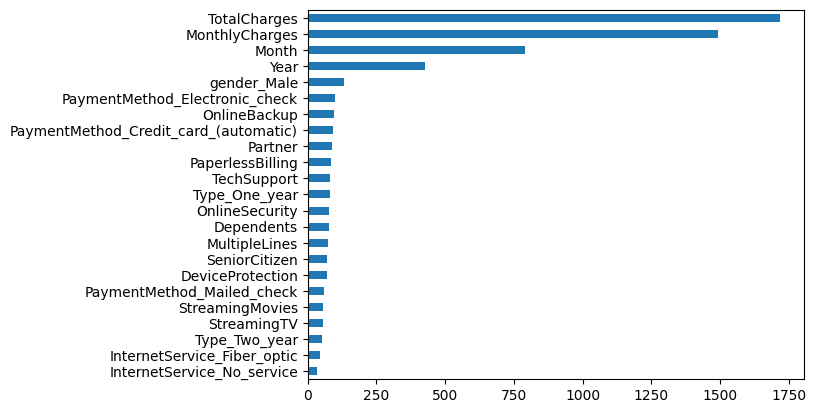

In [ ]:
# %%

importance = model_3.feature_importances_.tolist()

(pd.Series(importance, index=model_3.feature_name_)
 .sort_values(key=abs)
 .plot.barh()
)

In [ ]:
# %%

rfe = RFE(model_3, n_features_to_select=5)

rfe.fit(features_train, target_train)

pd.DataFrame({'features':features_train.columns,
              'support': rfe.support_,
              'ranking':rfe.ranking_}).sort_values('ranking')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1119, number of negative: 3106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264852 -> initscore=-1.020900
[LightGBM] [Info] Start training from score -1.020900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

,features,support,ranking
22,gender_Male,True,1
1,MonthlyCharges,True,1
2,TotalCharges,True,1
3,Month,True,1
4,Year,True,1
16,PaymentMethod_Electronic check,False,2
6,Partner,False,3
0,PaperlessBilling,False,4
13,StreamingTV,False,5
18,Type_One year,False,6


In [ ]:
# %%

%%time
best_5_features = ['gender_Male', 'MonthlyCharges', 'Month', 'Year', 'TotalCharges']

model_3_1 = LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, num_leaves=31).fit(features_train[best_5_features], target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_3_1, features=features_valid[best_5_features], target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1119, number of negative: 3106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264852 -> initscore=-1.020900
[LightGBM] [Info] Start training from score -1.020900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

# %% [markdown]

# Modelo 4 XGBoost

In [ ]:
# %%

%%time
model_4 = xgb.XGBClassifier(eval_metric='logloss', random_state=12345)

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1, 3, 5, 7, 9]
}

# Perform grid search
grid_search = GridSearchCV(model_4, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(features_train, target_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}
Best Score: 0.8762130177514793
CPU times: total: 6.53 s
Wall time: 13 s


In [ ]:
# %%

%%time
model_4 = xgb.XGBClassifier(eval_metric='logloss', random_state=12345, learning_rate= 0.2, max_depth=3, n_estimators=500)
model_4.fit(features_train, target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_4, features=features_valid, target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.9306324768809079
F1 score: 0.7792207792207793
Puntuación media de la evaluación del modelo: 0.8509477297392797
Matriz de confusion:
[[986  44]
 [109 270]]
CPU times: total: 24.3 s
Wall time: 1.83 s


<Axes: >

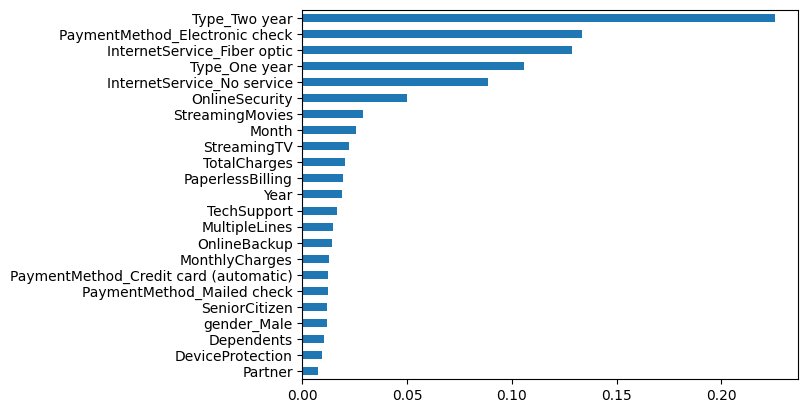

In [ ]:
# %%

pd.Series(model_4.feature_importances_, index=features_valid.columns).sort_values().tail(25).plot.barh()

In [ ]:
# %%

top_5_features = ['Type_Two year','PaymentMethod_Electronic check','InternetService_Fiber optic','Type_One year','Year']

model_4_1 = xgb.XGBClassifier(eval_metric='logloss', random_state=12345, learning_rate= 0.2, max_depth=3, n_estimators=500)
model_4_1.fit(features_train[top_5_features], target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_4_1, features=features_valid[top_5_features], target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.841240361708123
F1 score: 0.6013986013986014
Puntuación media de la evaluación del modelo: 0.7899270588829157
Matriz de confusion:
[[909 121]
 [164 215]]


# %% [markdown]

 Aunque la reduccion de dimensionalidad no mejoro las metricas, nuestro modelo original nos brindo resultados excelentes, hasta ahora los mejores.

# %% [markdown]

# Modelo 5 CatBoost

In [ ]:
# %%

# model_5 = CatBoostClassifier(random_state=12345, verbose=20, loss_function='Logloss', early_stopping_rounds=15)

# param_grid = {
#     'iterations': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'bagging_temperature': [0.1, 0.5, 1.0],
#     'rsm': [0.6, 0.8, 1.0]
# }

# # Perform grid search
# grid_search = GridSearchCV(model_5, param_grid, cv=5, verbose=1, n_jobs=-1).fit(features_train, target_train)

# # Best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

In [ ]:
# %%

%%time
model_5 = CatBoostClassifier(random_state=12345, verbose=20, loss_function='Logloss', early_stopping_rounds=20, depth=6, iterations=500,
l2_leaf_reg=9, learning_rate=0.1, rsm=0.6).fit(features_train, target_train)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_5, features=features_valid, target=target_valid)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

0:	learn: 0.6311279	total: 4.68ms	remaining: 2.34s
20:	learn: 0.3838892	total: 99.3ms	remaining: 2.27s
40:	learn: 0.3474759	total: 191ms	remaining: 2.14s
60:	learn: 0.3274179	total: 293ms	remaining: 2.11s
80:	learn: 0.3093149	total: 388ms	remaining: 2.01s
100:	learn: 0.2911301	total: 477ms	remaining: 1.88s
120:	learn: 0.2706068	total: 587ms	remaining: 1.84s
140:	learn: 0.2535770	total: 681ms	remaining: 1.73s
160:	learn: 0.2401290	total: 797ms	remaining: 1.68s
180:	learn: 0.2280894	total: 887ms	remaining: 1.56s
200:	learn: 0.2172876	total: 980ms	remaining: 1.46s
220:	learn: 0.2082019	total: 1.08s	remaining: 1.37s
240:	learn: 0.1996895	total: 1.18s	remaining: 1.27s
260:	learn: 0.1913943	total: 1.28s	remaining: 1.17s
280:	learn: 0.1841726	total: 1.39s	remaining: 1.08s
300:	learn: 0.1770896	total: 1.51s	remaining: 998ms
320:	learn: 0.1701494	total: 1.61s	remaining: 897ms
340:	learn: 0.1633562	total: 1.7s	remaining: 794ms
360:	learn: 0.1574257	total: 1.8s	remaining: 693ms
380:	learn: 0.1517

# %% [markdown]

 Los resultados fueron maravillos, pero no superaron a nuestro algoritmo previo.

# %% [markdown]

# Analisis de resultados
 ---
 Después de haber entrenado diferentes modelos utilizando una variedad de algoritmos y técnicas para simplificarlos y evaluarlos obtuvimos las siguientes conclusiones:
 - Los mejores resultados arrojados por la regresión logística fueron 0.86 para la curva AUC-ROC, 0.62 en valor F, y 0.81 en accuracy usando validación cruzada. Estos resultados fueron decentes y nos sirvieron como base para evaluar otros algoritmos.
 - Al momento de reducir la dimensionalidad en el algoritmo de bosque aleatorio, nuestros resultados mejoraron un poco, obtuvimos un 0.88 para la curva AUC-ROC, 0.68 en el valor F, y 0.83 en accuracy. Con este modelo se pudo apreciar una clara mejora en las predicciones.
 - Nuestros resultados dieron un gran salto al utilizar la librería LightGBM, este modelo nos brindó un 0.92 en la curva AUC-ROC, 0.77 en el valor F, y 0.84 en accuracy.
 - La poderosa librería de XGBoost nos arrojó los mejores resultados utilizando nuestro dataset de validación, 0.93 en la curva AUC-ROC, casi 0.78 en el valor F, y 0.85 en accuracy. Se puede apreciar la potencia que tienen los modelos basados en boosting.
 - Por último, entrenamos un modelo utilizando la potente librería CatBoost. Los resultados también estuvieron a la altura, aunque no superaron a los ofrecidos por el último modelo entrenado, estos fueron 0.92 en la curva AUC-ROC, 0.76 en el valor F, y 0.85 en accuracy.

# %% [markdown]

# Seleccion del mejor modelo y validacion con dataset de pruebas

In [ ]:
# %%

%%time
auc_roc, f1, final_score, confusion_matriz = metrics(model=model_4, features=features_test, target=target_test)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.9309552373681504
F1 score: 0.7720364741641338
Puntuación media de la evaluación del modelo: 0.8431614547840791
Matriz de confusion:
[[1005   33]
 [ 117  254]]
CPU times: total: 20.4 s
Wall time: 1.61 s


# %% [markdown]

 Tenemos resultados excelentes con el conjunto de datos para pruebas, en mi opinion este modelo podria ser lanzado a produccion.